
Here we include the neural network model in PyMC3, utilizing Theano tensors to reconstruct the net.

In [1]:
%pylab inline
import pymc3 as pm
import os
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
a=ModelParameters()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load in the neural network weights
model_numpy=np.load("/home/oliverphilcox/ChempyMulti/stacked_8_element_net_large.npz")
w_array_0=np.matrix(model_numpy["w0"])
b_array_0=np.matrix(model_numpy["b0"])
w_array_1=np.matrix(model_numpy["w1"])
b_array_1=np.matrix(model_numpy["b1"])
# Load standardization parameters
input_mean=model_numpy.f.in_mean
input_std=model_numpy.f.in_std
output_mean=model_numpy.f.out_mean
output_std=model_numpy.f.out_std

In [51]:
## Load in mock dataset
mock_data=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Mock_Data.npz') #dataset
n_stars = 10#0#len(mock_data.f.abundances)

indices = np.random.randint(0,len(mock_data.f.obs_time),n_stars)

mu_times = mock_data.f.obs_time[indices] #time of birth
sigma_times = mock_data.f.obs_time_err[indices] #error on age
all_els = mock_data.f.elements

full_abundances = mock_data.f.abundances[indices] # chemical element abundances for data
full_errors = mock_data.f.abundance_errs[indices] # error on abundances

In [101]:
# Filter out correct elements:
els = ['C','Fe','He','Mg','N','Ne','O','Si'] # TNG elements
n_els = len(els)

el_indices=np.zeros(len(els),dtype=int)
for e,el in enumerate(els):
    for j in range(len(all_els)):
        if els[e]==str(all_els[j]):
            el_indices[e]=j
            break
        if j==len(all_els)-1:
            print("Failed to find element %s"%el)
obs_abundances = full_abundances[:,el_indices]
obs_errors = full_errors[:,el_indices]

In [66]:
true_Times=mock_data.f.true_time[indices]
true_Lambda = [-2.3,-2.89]
true_Thetas = np.ones([len(indices),3])*np.inf # unknown

In [54]:
# Now standardize dataset
norm_data=(obs_abundances-output_mean)/output_std # use only 6 elements
norm_sd = obs_errors/output_std

In [55]:
data_obs = norm_data.ravel()
data_sd = np.asarray(norm_sd).ravel()

In [56]:
# Define priors
Lambda_prior_mean = a.p0[:2]
Theta_prior_mean = a.p0[2:]
Lambda_prior_width = [0.3,0.3]
Theta_prior_width = [0.3,0.1,0.1]
# Now standardize
std_Lambda_prior_mean = (Lambda_prior_mean-input_mean[:2])/input_std[:2]
std_Lambda_prior_width = (Lambda_prior_width)/input_std[:2]
std_Theta_prior_mean = (Theta_prior_mean-input_mean[2:5])/input_std[2:5]
std_Theta_prior_width = (Theta_prior_width)/input_std[2:5]
std_times_mean = (mu_times-input_mean[-1])/input_std[-1]
std_times_width = sigma_times/input_std[-1]

# Define critical theta edge:
log_SFR_crit = 0.29402
std_log_SFR_crit = (log_SFR_crit-input_mean[3])/input_std[3]

# Define bounds on age to stop predicting out of parameter space:
min_time,max_time = [0.,13.5]
std_min_time,std_max_time=[(time-input_mean[-1])/input_std[-1] for time in [min_time,max_time]]

In [57]:
# Define stacked local priors
Local_prior_mean = np.vstack([np.hstack([std_Theta_prior_mean,std_times_mean[i]]) for i in range(n_stars)])
Local_prior_sigma = np.vstack([np.hstack([std_Theta_prior_width,std_times_width[i]]) for i in range(n_stars)])

In [128]:
import pymc3.math as ma
import theano.tensor as tt

import os

use_model_errors = False


simple_model=pm.Model()
TruncatedNormal = pm.Bound(pm.Normal,lower=std_log_SFR_crit)
WideTruncatedNormal = pm.Bound(pm.Normal,lower=-1.5,upper=1.5) # 3sigma ranges for each parameter
AgeNormal = pm.Bound(pm.Normal,lower=std_min_time,upper=std_max_time)

# Share theano variables
w0=tt._shared(w_array_0)
b0=tt._shared(b_array_0)
w1=tt._shared(w_array_1)
b1=tt._shared(b_array_1)
ones_tensor = tt.ones([n_stars,1])

with simple_model:
    
    # Define priors
    Lambda = WideTruncatedNormal('Std-Lambda',mu=std_Lambda_prior_mean,sd=std_Lambda_prior_width,shape=(1,len(std_Lambda_prior_mean)))
    Theta1 = WideTruncatedNormal('Std-Theta1',mu=std_Theta_prior_mean[0],sd=std_Theta_prior_width[0],shape=(1,n_stars))
    Theta2 = TruncatedNormal('Std-Theta2',mu=std_Theta_prior_mean[1],sd=std_Theta_prior_width[1],shape=(1,n_stars))
    Theta3 = WideTruncatedNormal('Std-Theta3',mu=std_Theta_prior_mean[2],sd=std_Theta_prior_width[2],shape=(1,n_stars))
    Thetas = ma.concatenate([Theta1,Theta2,Theta3]).T
    #Thetas = pm.Normal('Std-Thetas',mu=std_Theta_prior_mean,sd=std_Theta_prior_width,shape=(n_stars,len(std_Theta_prior_mean)))
    Times = AgeNormal('Std-Times',mu=std_times_mean,sd=std_times_width,shape=(1,n_stars))
    
    TruLa = pm.Deterministic('Lambda',Lambda*input_std[:2]+input_mean[:2])
    TruTh = pm.Deterministic('Thetas',Thetas*input_std[2:5]+input_mean[2:5])
    TruTi = pm.Deterministic('Times',Times*input_std[-1]+input_mean[-1])
    
    # Define input parameter matrix
    Lambda_all = ma.matrix_dot(ones_tensor,Lambda)
    InputVariables = ma.concatenate([Lambda_all,Thetas,Times.T,np.square(Times.T)],axis=1)
    
    # Define neural network output
    #Layer 1: (N_el,20) Tanh w0,b0
    #Output Layer: (20,N_el) w1,b1
    layer1 = ma.matrix_dot(InputVariables,w0)+ma.matrix_dot(ones_tensor,b0)
    output = ma.matrix_dot(ma.tanh(layer1),w1)+ma.matrix_dot(ones_tensor,b1)
    
    network_output = pm.Deterministic("Neural Network",output)
    
    predictions = pm.Deterministic("Predicted-Abundances",output*output_std+output_mean)
    
    
    if use_model_errors:
        model_errors = pm.HalfCauchy('model_errors',beta=20,shape=(1,n_els))
        stacked_error = ma.matrix_dot(ones_tensor,model_errors)
        tot_error = ma.sqrt(stacked_error**2.+data_sd.reshape(n_stars,n_els)**2.)
    else:
        tot_error = data_sd
    
    # Define likelihood function (unravelling output to make a multivariate gaussian)
    likelihood=pm.Normal('likelihood', mu=output.ravel(), sd=tot_error.ravel(), observed=data_obs)

INFO (theano.gof.compilelock): Refreshing lock /home/oliverphilcox/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.7.0-64/lock_dir/lock


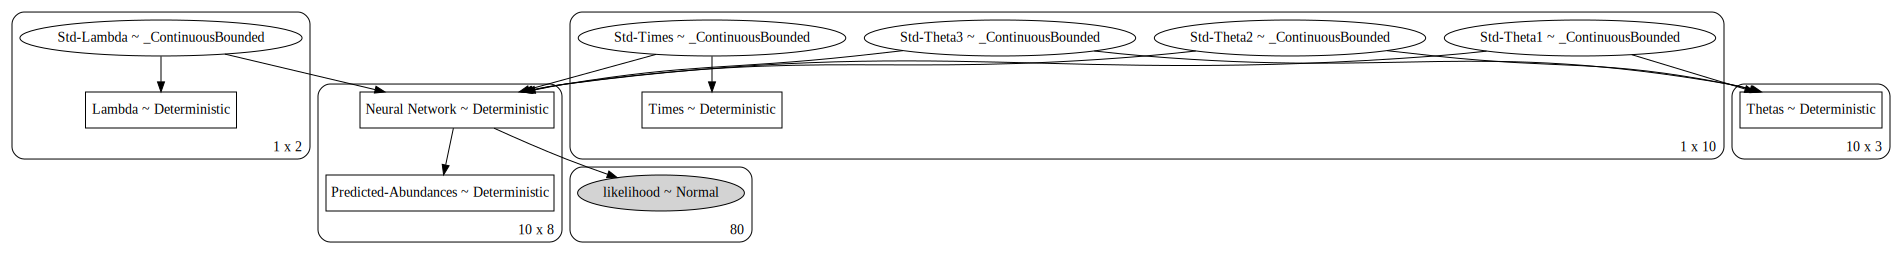

In [129]:
pm.model_to_graphviz(simple_model)

## SFR seems to sample outside of bounds??

In [130]:
# Now sample
with simple_model:
    samples=pm.sample(draws=2000,chains=4,cores=4,tune=3000,nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Std-Times, Std-Theta3, Std-Theta2, Std-Theta1, Std-Lambda]
Sampling 4 chains: 100%|██████████| 20000/20000 [01:24<00:00, 237.77draws/s]
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 25% for some parameters.


In [131]:
pm.summary(samples,varnames=['Lambda']).round(4)

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Lambda__0_0,-1.4531,0.0423,0.0006,-1.5367,-1.4009,4125.7472,1.0001
Lambda__0_1,-3.4410,0.0725,0.0013,-3.5945,-3.3070,2609.3076,1.0002


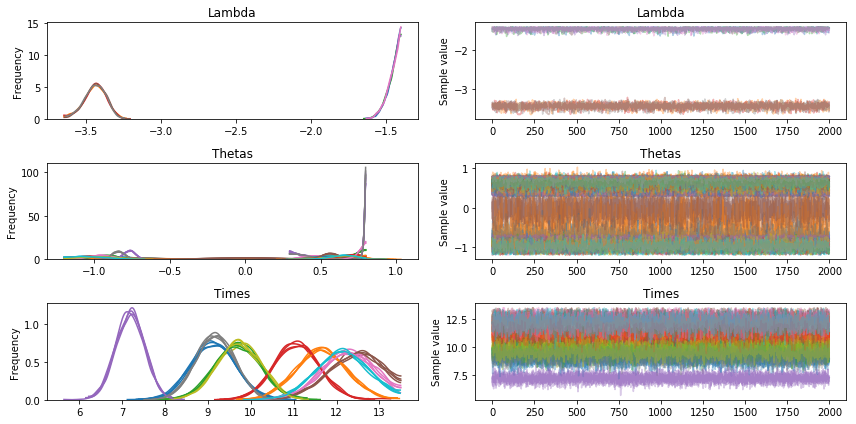

In [132]:
pm.traceplot(samples,varnames=['Lambda','Thetas','Times']);

In [133]:
def construct_output(samples):
    Lambda=samples.get_values('Lambda')[:,0,:]
    Thetas=samples.get_values('Thetas')[:,:,:]
    Times=samples.get_values('Times')[:,0,:]
    return Lambda,Thetas,Times

def single_star_output(samples,star_no):
    Lambda=samples.get_values('Lambda')[:,0,:]
    Thetas=samples.get_values('Thetas')[:,star_no,:]
    Times=samples.get_values('Times')[:,0,star_no].reshape(len(Lambda),1)
    return Lambda,Thetas,Times

In [134]:
Lambda,Thetas,Times=construct_output(samples)

Corner Plot for All Stars

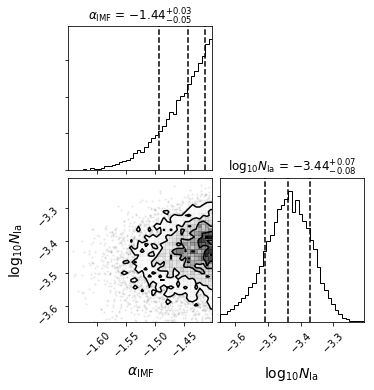

In [135]:
import corner
corner.corner(Lambda,show_titles=True,quantiles=[0.17,0.5,0.83],use_math_text=True,label_kwargs={'fontsize': 14},
              labels=[r'$\alpha_\mathrm{IMF}$',r'$\log_{10}N_\mathrm{Ia}$'],bins=40,truths=true_Lambda);

Corner plot for single star (with $1\sigma$ Gaussian smoothing):

In [136]:
from scipy.stats import truncnorm

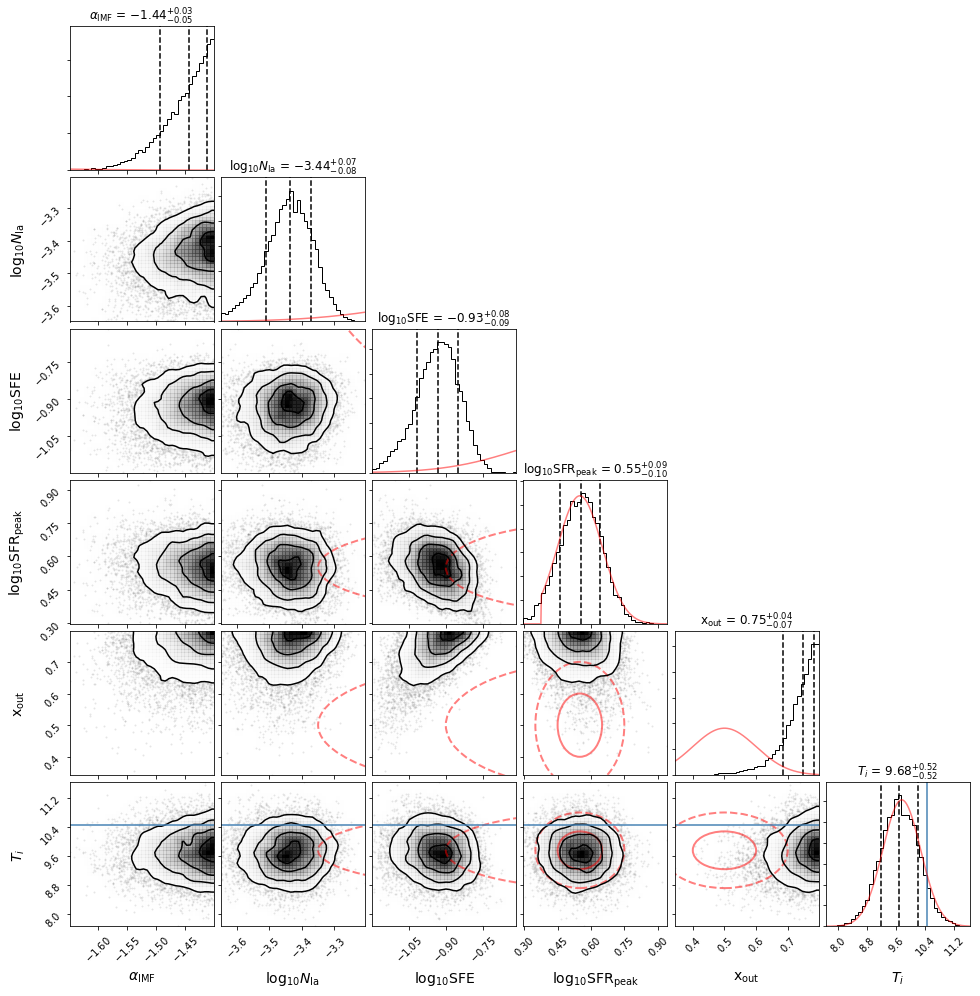

In [137]:
star_index=2
Lambda,Theta1,Times1=single_star_output(samples,star_index)

true_params = np.hstack([true_Lambda,true_Thetas[star_index],true_Times[star_index]])

n_bins=40
names = [r'$\alpha_\mathrm{IMF}$',r'$\log_{10}N_\mathrm{Ia}$',r'$\log_{10}\mathrm{SFE}$',
         r'$\log_{10}\mathrm{SFR}_\mathrm{peak}$',r'$\mathrm{x}_\mathrm{out}$',r'$T_i$']
priors = list(a.p0)+[mu_times[star_index]]
prior_widths = list(np.hstack([Lambda_prior_width,Theta_prior_width]))+[sigma_times[star_index]]
all_dat=np.hstack([Lambda,Theta1,Times1])
figure=corner.corner(all_dat,show_titles=True,quantiles=[0.17,0.5,0.83],truths=true_params,
                     use_math_text=True,label_kwargs={'fontsize': 14},
                     labels=names,bins=n_bins,scale_hist=False,smooth=1.);

integ=np.zeros(len(all_dat[0]))
for i in range(len(all_dat[0])):
    ct,x,=np.histogram(all_dat[:,i],bins=n_bins)
    integ[i]=np.sum(np.diff(x)*ct)

from matplotlib.patches import Ellipse

# Extract the axes
ndim=len(priors)
axes = np.array(figure.axes).reshape((ndim, ndim))

from scipy.stats import norm

for yi in range(ndim):
    xi=yi
    ax=axes[yi,xi]
    xdata=np.linspace(priors[xi]-10*prior_widths[xi],priors[xi]+10*prior_widths[xi],1000)
    if yi==3:
        ax.plot(xdata,integ[yi]*truncnorm.pdf(xdata,std_log_SFR_crit,np.inf,loc=priors[xi],scale=prior_widths[xi]),c='r',alpha=0.5)
    else:
        ax.plot(xdata,integ[yi]*norm.pdf(xdata,loc=priors[xi],scale=prior_widths[xi]),c='r',alpha=0.5)

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        el=Ellipse([priors[xi],priors[yi]],2*prior_widths[xi],2*prior_widths[yi],
                   facecolor='none',edgecolor='r', lw=2,alpha=0.5)
        el2=Ellipse([priors[xi],priors[yi]],4*prior_widths[xi],4*prior_widths[yi],
                   facecolor='none',edgecolor='r', lw=2,alpha=0.5,ls='--')
        ax.add_artist(el)
        ax.add_artist(el2)

In [71]:
def plotautocorr(samples,max_lags=30,burn_in=100):
    FS=16
    lambda_samples=samples['Lambda'][:,0,:][burn_in:]
    fig,ax=plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True)
    for l,lam in enumerate(lambda_samples.T):
        ax[l].acorr(lam, detrend=plt.mlab.detrend_mean,maxlags=max_lags)
        ax[l].set_ylabel(r"$\Lambda_{%d}$"%(l+1),fontsize=FS)
        ax[l].set_xlim(0, max_lags)

    ax[1].set_xlabel("Lag",fontsize=FS)
    ax[0].set_title(r"$\Lambda$ Autocorrelation Plot using %d burn-in samples"%burn_in,fontsize=FS);   

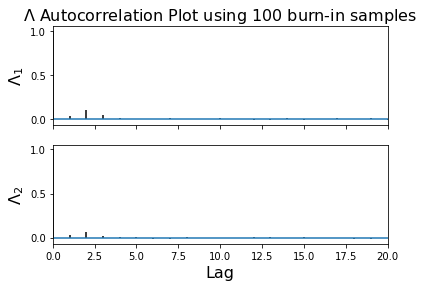

In [72]:
plotautocorr(samples,burn_in=100,max_lags=20);

Plot PPC:

In [73]:
def net_standard_output(standard_in_par):
    """Return neural network output (in standardized form)"""
    l1=np.matmul(np.asmatrix(standard_in_par),w_array_0)+b_array_0
    standard_out=np.matmul(np.tanh(l1),w_array_1)+b_array_1
    return np.asarray(standard_out)
def net_output(in_par):
    """Return physics neural network output for destandardized parameters"""
    # Standardize input:
    standard_in=(in_par-input_mean)/input_std
    sq_in = np.asarray(list(standard_in)+[standard_in[-1]**2.])
    # Reconstruct network
    standard_out=net_standard_output(sq_in)
    # Destandardize output
    out = np.asarray(standard_out)*output_std+output_mean
    return out

#### Let's see what's happening for star 4 (at large time)

In [74]:
La,Th,Ti = single_star_output(samples,4)
params=np.hstack([La,Th,Ti])
med_params=np.median(params,axis=0)
true_params=np.hstack([true_Lambda,true_Thetas[4],true_Times[4]])
print(med_params)
print(true_params)

[-0.04763795 -2.80549975 -0.62294669  0.35294861  1.09941     7.27473051]
[-2.3        -2.89               inf         inf         inf  6.52141032]


In [75]:
all_ppc_abun=[]
for star_index in range(n_stars):
    Lambda,Theta1,Times1=single_star_output(samples,star_index)
    all_par=np.hstack([Lambda,Theta1,Times1])
    ppc_abun = np.asarray([net_output(pp) for pp in all_par])
    all_ppc_abun.append(ppc_abun)

In [76]:
all_ppc_abun[0].shape

(8000, 1, 8)

In [77]:
def alpha_abun(abun_arr,err=False):
    for e in range(len(els)):
        if str(els[e])=='O':
            indO=e
        if str(els[e])=='Mg':
            indMg=e
        if str(els[e])=='Si':
            indSi=e
        if str(els[e])=='Fe':
            indFe=e
    if err:
        ab_alpha = np.sqrt(abun_arr[indFe]**2.+((abun_arr[indO]*16.)**2.+(abun_arr[indMg]*24.)**2.+(abun_arr[indSi]*28.)**2.)/(16.+24.+28.)**2.)
    else:
        ab_alpha = (abun_arr[indO]*16.+abun_arr[indMg]*24.+abun_arr[indSi]*28.)/(16.+24.+28.)-abun_arr[indFe]
    return abun_arr[indFe],ab_alpha

In [78]:
ppc_perc

NameError: name 'ppc_perc' is not defined

<ErrorbarContainer object of 3 artists>

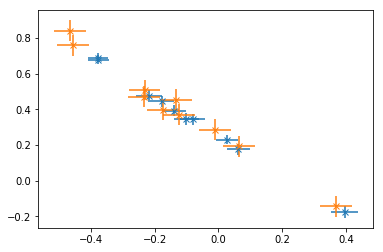

In [81]:
up,med,lo=[],[],[]
for i in range(n_stars):
    ppc_perc = np.percentile(all_ppc_abun[i][:,0,:],[17.,50.,83.],axis=0)
    med.append(alpha_abun(ppc_perc[1]))
    up.append(alpha_abun(ppc_perc[2]))
    lo.append(alpha_abun(ppc_perc[0]))
med=np.asarray(med)
up=np.asarray(up)
lo=np.asarray(lo)
plt.errorbar(med[:,0],med[:,1],yerr=[med[:,1]-lo[:,1],up[:,1]-med[:,1]],
             xerr=[med[:,0]-lo[:,0],up[:,0]-med[:,0]],marker='x',ls='')
obs_dat=[];obs_err=[]
for i in range(n_stars):
    obs_dat.append(alpha_abun(obs_abundances[i]))
    obs_err.append(alpha_abun(obs_errors[i],err=True))
plt.errorbar(np.asarray(obs_dat)[:,0],np.asarray(obs_dat)[:,1],marker='x',ls='',
            yerr=np.asarray(obs_err)[:,1],xerr=np.asarray(obs_err)[:,0])


In [82]:
np.asarray(obs_dat)

array([[-0.00935459,  0.28477179],
       [ 0.06493735,  0.19245092],
       [-0.23437786,  0.46940677],
       [-0.1732862 ,  0.39559748],
       [-0.46683908,  0.84055664],
       [ 0.36900806, -0.14344627],
       [-0.23160648,  0.50840952],
       [-0.45519471,  0.75897927],
       [-0.13305664,  0.45329924],
       [-0.12409902,  0.36918051]])

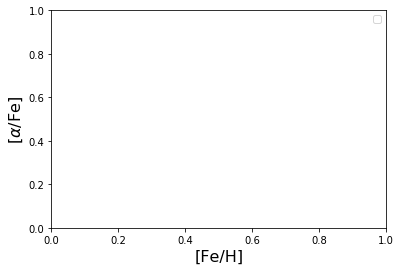

In [642]:
len_T = len(np.unique(true_Times))
labels = ['Vanilla','Low SFE','Bursty SFR','Leaky ISM']
c=['k','r','g','b']
for index in range(n_stars//len_T):
    oFeH,oAlFe,oFeHSig,oAlFeSig=[np.zeros(len_T) for _ in range(4)]
    FeH,AlFe,FeHL,FeHH,AlFeL,AlFeH=[np.zeros(len_T) for _ in range(6)]
    for j in range(len_T):
        star_index = index*len_T+j
        this_ppc_perc = np.percentile(all_ppc_abun[star_index][:,0,:],[17.,50.,83.],axis=0)
        oFeH[j],oAlFe[j] = alpha_abun(obs_abundances[star_index])
        oFeHSig[j],oAlFeSig[j] = alpha_abun(obs_errors[star_index],err=True)
        FeH[j],AlFe[j] = alpha_abun(this_ppc_perc[1])
        FeHL[j],AlFeL[j] = alpha_abun(this_ppc_perc[0])
        FeHH[j],AlFeH[j] = alpha_abun(this_ppc_perc[2])
    plt.errorbar(oFeH,oAlFe,xerr=oFeHSig,yerr=oAlFeSig,ls='--',label=labels[index],c=c[index],alpha=0.1)
    plt.errorbar(FeH,AlFe,xerr=[FeH-FeHL,FeHH-FeH],yerr=[AlFe-AlFeL,AlFeH-AlFe],ls='-',c=c[index])
plt.legend();plt.ylabel(r'[$\alpha$/Fe]',fontsize=16);plt.xlabel('[Fe/H]',fontsize=16);